In [1]:
import torch as t
import pandas as pd
import numpy as np
from tqdm import tqdm

from torch.nn import GRU
from src.preprocess import *

import warnings
warnings.simplefilter('ignore')


In [ ]:
# setting up
DEVICE = 'cuda' if t.cuda.is_available() else 'cpu'
DEVICE = 'mbp' if t.backends.mps.is_available() else DEVICE
DATASET_PATH = './dataset/result.csv'
LOOK_FWD = 700
W_SIZE = 500
THR = 0.000001
TRAIN_TEST_R = 0.8
TRAIN_VAL_R = 0.8

In [2]:
unzip_dataset('./dataset/')
dataset = pd.read_csv(DATASET_PATH, index_col=0)
dataset.shape

Dataset already extracted


(4382993, 79)

In [3]:
labels = generate_labels(dataset, LOOK_FWD, THR)[LOOK_FWD:]

100%|██████████████████████████████| 4382293/4382293 [02:14<00:00, 32587.84it/s]


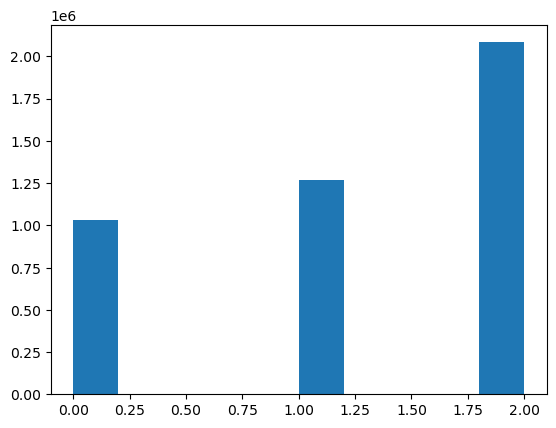

In [4]:
import matplotlib.pyplot as plt
plt.hist(labels)
plt.show()

In [5]:
labels.shape

(4381593,)

In [6]:
pipe = Pipe(W_SIZE)

train_index = int((dataset.shape[0] - LOOK_FWD * 2 - W_SIZE) * TRAIN_TEST_R)
test_index_start = train_index + W_SIZE
ds_train = dataset[:train_index]
ds_test = dataset[test_index_start: - LOOK_FWD * 2]

pipe.fit(ds_train)

train_t = pipe.transform(ds_train)
test_t = pipe.transform(ds_test)

train_l_t = t.tensor(labels[:train_t.shape[0]])
test_l_t = t.tensor(labels[test_index_start:test_index_start + test_t.shape[0]])

train_val_idx = int(train_l_t.shape[0] * TRAIN_VAL_R)

train_ds = t.utils.data.TensorDataset(train_t[:train_val_idx], train_l_t[:train_val_idx])
val_ds = t.utils.data.TensorDataset(train_t[train_val_idx:], train_l_t[train_val_idx:])
test_ds = t.utils.data.TensorDataset(test_t, test_l_t)

train_dl = t.utils.data.DataLoader(train_ds, batch_size=512)
val_dl = t.utils.data.DataLoader(val_ds, batch_size=512)
test_dl = t.utils.data.DataLoader(test_ds, batch_size=512)

In [7]:
class Att_GRU(t.nn.Module):
    def __init__(self, f_dim, n_layers, hidden, window, device='cpu'):
        super().__init__()

        self.f_dim = f_dim
        self.hidden = hidden

        self.att_1 = t.nn.Parameter(t.rand((1, f_dim, f_dim), dtype=t.float32, requires_grad=True)).to(device=device)

        self.att_2 = t.nn.Parameter(t.randn((1, hidden, hidden), dtype=t.float32, requires_grad=True)).to(device=device)
        self.sm = t.nn.Softmax(dim=1)

        self.gru = GRU(
            input_size = f_dim,
            hidden_size = hidden,
            num_layers = n_layers,
            bidirectional=False
        )

        self.w = t.nn.Linear(hidden * window, 3)

    def forward(self, x):
        # first attention stage
        pr = self.att_1.repeat(x.shape[0],1,1)
        pr = t.bmm(x, pr)
        pr = (self.sm(pr).sum(2) / self.f_dim)\
            .unsqueeze(1)\
            .repeat(1, self.f_dim, 1)\
            .permute(0,2,1)
        x = pr * x

        # gru
        x, _ = self.gru(x)

        # second attention stage
        pr = self.att_2.repeat(x.shape[0],1,1)
        pr = t.bmm(x, pr)
        pr = (self.sm(pr).sum(2) / self.hidden)\
            .unsqueeze(1)\
            .repeat(1, self.hidden, 1)\
            .permute(0,2,1)
        
        x = (pr * x).flatten(1)
        x = self.w(x)
        x = self.sm(x)

        return x



In [8]:
model = Att_GRU(train_t.shape[2], 5, 20, W_SIZE)
model(train_t[500:505]).shape

torch.Size([5, 3])

In [9]:
def train(train_loader, val_loader, model, optimizer, lf, epochs=10, device='cpu'):
    bar = tqdm(range(epochs))
    epoch_loss = -1.0
    eval_loss = -1.0
    for epoch in bar:
        l = 0

        batch_count = 0
        for X, y in train_loader:
            batch_count += 1
            
            optimizer.zero_grad()
            X = X.to(device=device)
            out = model(X).to(device='cpu')
            loss = lf(out, y)
            loss.backward()
            l += loss
            optimizer.step()

            bar.set_description("train_loss: {:.3f}, eval_loss: {:.3f}, local_loss: {:.3f}"\
                                .format(epoch_loss, eval_loss, loss))

        epoch_loss = l / batch_count
        eval_loss = eval(val_loader, model, lf, device)

def eval(val_loader, model, lf, device='cpu'):
    with t.no_grad():
        loss = 0
        batch_counter = 0
        for X, y in bar:
            batch_counter += 1
            l = 0
            out = model(X.to(device=device))
            loss += lf(out, y)
    return loss / batch_counter


In [10]:
%%time
model_1 = Att_GRU(test_t.shape[2],
                  n_layers=5,
                  hidden=100,
                  device=DEVICE,
                  window=W_SIZE)
optimizer = t.optim.Adam(model.parameters())
lf = t.nn.CrossEntropyLoss()

train(train_dl, val_dl, model, optimizer, lf, 3)

RuntimeError: Expected one of cpu, cuda, ipu, xpu, mkldnn, opengl, opencl, ideep, hip, ve, fpga, ort, xla, lazy, vulkan, mps, meta, hpu, privateuseone device type at start of device string: mbp

In [11]:
# params
items = 3
sequence_len = 10
features = 20
K = 6
n_layers = 2

# test tensor
test = t.randn((items, sequence_len, features))

# init of first hidden state
h_0 = t.randn((n_layers, sequence_len, K))
gru = GRU(
    input_size = features,
    hidden_size = K,
    num_layers = n_layers,
    bidirectional=False
)

gru(test, h_0)[0].shape

torch.Size([3, 10, 6])